# EPyG - Extended Phase Graphs in Python

## Introduction

EPyG aims towards an implementation of the Extendended Phase Graph algorithm as introduced by Hennig [2,3]. Particularly it resembles the operator notation introduced by Weigel [1]

 1. Weigel M, Schwenk S, Kiselev VG, Scheffler K, Hennig J. Extended phase graphs with anisotropic diffusion. J Magn Reson 2010;205:276–85. doi: 10.1016/j.jmr.2010.05.011.
 2. Hennig J. Echoes -How to Generate, Recognize,  Use or Avoid Them in MR-Imaging  Sequences  Part 2: Echoes in Imaging Sequences . Concepts Magn Reson 1991;3:179–192.
 3. Hennig J. Echoes -How to Generate , Recognize , Use or Avoid Them in MR-Imaging Sequences Part I : Fundamental and Not So Fundamental Properties of Spin Echoes. 1991:125–143.
 4. Scheffler K. A Pictorial Description of Steady-States in Rapid Magnetic Resonance Imaging. Concepts Magn Reson Part A 1999:291–304.

## Basics

In [1]:
%pylab inline
%matplotlib inline
plt.style.use("ggplot")
import numpy as np
from epyg import EpyG, Operators
from epyg import Operators as operators

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


A phase graph object represents a manifold dephased magnetisation state. The epg itself has no methods and/or paramters. That means also relaxation parameters and meq are contained in the corresponding operators. Therefore we usually start with an initial phase graph object with only non-dephased longitudinal magnetisation

In [2]:
phase_graph = EpyG.epg(initial_size=512, m0=1.0)

The initial_size attribute specifies the size of the internal data buffer. Usually this parameter does not need to be changed as the epg object should grow when necessary. m0 is the initial magnetisation in the non-dephased m0 state.

In [3]:
phase_graph

ValueError: Integers to negative integer powers are not allowed.

As we can see a phase graph has a rich representation in the notebook showing its populates states. For our baseline graph this is just Z_0

Modification of the phase graph opject is only intended through corresponding operators with naming adapted from the publication by Weigel et al.
 * RF Pulses : Transform
 * Dephasing : Shift
 * Epsilon : Relaxation
 
Please keep in mind that the operators modify the epg in place! 

We now create some basic Operators for exciting with 90deg with 0 phase. I.e. a rotation around the x-axis. Please note that all angles need to be entered in radian!

In [4]:
T = operators.Transform(alpha=np.deg2rad(90.0), phi=0.0, name="Excitation")
T

In [5]:
T*phase_graph

k,0
F+,0.000+1.000j
F-,0.000-1.000j
Z,0.000+0.000j


We see that after the 90deg excitation we now have a non-dephased transverse state. We continue with a shift operator that represents dephasing generated by gradients of 1 FOV.

In [6]:
S = operators.Shift(shifts=1, autogrow=True, name="Dephase")
S

In [7]:
S*phase_graph

k,0,1
F+,0.000-0.000j,0.000+1.000j
F-,0.000+0.000j,0.000+0.000j
Z,0.000+0.000j,0.000+0.000j


Of course negative (rephasing) shifts are possible

In [8]:
Sback = operators.Shift(shifts=-1, autogrow=True, name="Rephase")
Sback*phase_graph

k,0
F+,0.000+1.000j
F-,0.000-1.000j
Z,0.000+0.000j


Application of the shift operator dephases the transverse magnetisation. Now let's relax the magnetisation

In [9]:
TR=10.0 
T1=1000.0
T2=100.0

E = operators.Epsilon(TR_over_T1=TR/T1, TR_over_T2=TR/T2, name="Relaxation")
E

In [10]:
E*phase_graph

k,0
F+,0.000+0.905j
F-,0.000-0.905j
Z,0.010+0.000j


We can see how the transverse magnetisation decays and how the longitudinal magnetisation regrows in the Z_0 state. Those operations constitue a basic gradient echo experiment where the signal corresponds to the magnitude of the F0 state after the RF pulse. To facilitate signal detecion an Observer exists that can record magnetisation states (does not alter epg state, just for convenience)

In [11]:
O = operators.Observer(f_states=(0,), z_states=(0,), name="ADC")
O

F0
Z0


To allow for easier application operators can be grouped to a *CompositeOperator*. We use this now to simulate a (non RF spoiled) GRE sequence. For this purpose we also utilize a redued flip angle of 10deg to have a usable signal.

In [12]:
T_small = operators.Transform(alpha=np.deg2rad(10.0), phi=0.0, name="Low Tip Excitation")
c = operators.CompositeOperator(T_small,O,S,E,name="GRE")
c

F0
Z0


The following code now performs a consecutive GREs followed by a relaxation period. Please note the execution order of the composite operator - it uses the more natural representation that what was supplied first in the constructor is applied first. E.g. in the present case Transform is applied before Shift followed by Epsilon.

In [13]:
gre_graph = epg.EpyG(initial_size=256, m0=1.0)
# FLASH 
for i in range(350):
    c*gre_graph
S*gre_graph
# Relax afterwards
for i in range(500):
    E*gre_graph
    O*gre_graph
O

F0,0.000+0.000j,0.000+0.000j,0.000-0.001j,0.000-0.003j,0.000-0.006j,0.000-0.010j,0.000-0.014j,0.000-0.018j,0.000-0.023j,0.000-0.028j,0.000-0.032j,0.000-0.037j,0.000-0.041j,0.000-0.045j,0.000-0.049j,0.000-0.052j,0.000-0.055j,0.000-0.057j,0.000-0.059j,0.000-0.061j,0.000-0.062j,0.000-0.062j,0.000-0.063j,0.000-0.063j,0.000-0.063j,0.000-0.062j,0.000-0.062j,0.000-0.061j,0.000-0.060j,0.000-0.059j,0.000-0.058j,0.000-0.057j,0.000-0.056j,0.000-0.055j,0.000-0.055j,0.000-0.054j,0.000-0.053j,0.000-0.053j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.054j,0.000-0.054j,0.000-0.054j,0.000-0.054j,0.000-0.054j,0.000-0.054j,0.000-0.054j,0.000-0.054j,0.000-0.054j,0.000-0.054j,0.000-0.054j,0.000-0.054j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.053j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.052j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.051j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-0.050j,0.000-

As we can see the observer has now (as requested) recorded the F0 and ZO state. Those can be retrieved via the get_F and get_Z methods (which take the order as arguments). Values are returned as numpy arrays. This can then be used to plot the corresponding magnetisation

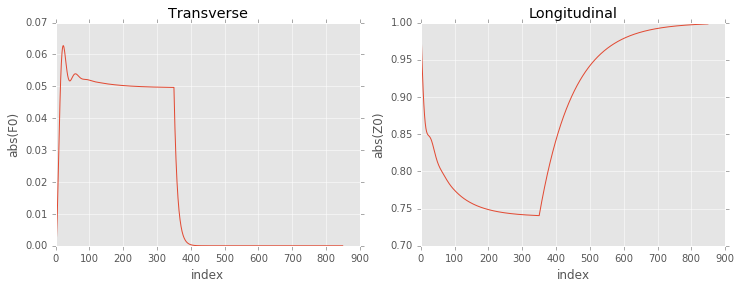

In [14]:
f_, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(12,4))
ax1.plot(np.abs(O.get_f(0)))
ax1.set_xlabel("index")
ax1.set_ylabel("abs(F0)")
ax1.set_title("Transverse")

ax2.set_title("Longitudinal")
ax2.plot(np.abs(O.get_z(0)))
ax2.set_xlabel("index")
ax2.set_ylabel("abs(Z0)");

## Simulating an RF Spoiled GRE Sequence - FLASH

The above samples show the basics for sequence simulation. Now we show the (important) example of analyzing a RF spoiled sequence were the RF spoiling phase is incremented by a term

$$
\Phi_{n+1} = \Phi_{n} + n*\theta
$$

where $\theta$ is phase increment that needs to be determined numerically. Common values are 50deg and 117deg. To handle this the phase of the Transform operator coud be updated each iteration. Alternatively a ready made Operator for RF spoiling is availble.

In [15]:
alpha = 10.0  # Flip angle
N = 256  # Number of pulses
T1 = 1000.0
T2 = 150.0
TR = 10.0
phinc = deg2rad(50.0)

# The Operators - we reuse S from above
T = operators.PhaseIncrementedTransform(alpha=np.deg2rad(alpha), phi=0.0, linear_phase_inc=0.0, name="Excite")
Trf = operators.PhaseIncrementedTransform(alpha=np.deg2rad(alpha), phi=0.0, linear_phase_inc=phinc, name="RFSpoiled_Excite")

# Very rapid transverse relaxation for now
E_fast = operators.Epsilon(TR_over_T1=TR/T1, TR_over_T2=TR/T2)

O_spoil = operators.Observer(f_states=(0,1,-1), z_states=(0,))
O_nospoil = operators.Observer(f_states=(0,1,-1), z_states=(0,))

cspoil = operators.CompositeOperator(E_fast,S,O_spoil,Trf)
cnospoil = operators.CompositeOperator(E_fast,S,O_nospoil,T)

# The EPGs
nospoil_graph = epg.EpyG(initial_size=256, m0=1.0)
rfspoil_graph = epg.EpyG(initial_size=256, m0=1.0)

# FLASH 
for i in range(N):
    cspoil*rfspoil_graph
    cnospoil*nospoil_graph

In [16]:
def ernst(TR,T1,alpha):
    '''
    The Ernst signal - for comparison with the numerical results
    '''
    E1 = exp(-TR/T1)
    return sin(alpha) * (1.0-E1)/(1.0-E1*cos(alpha))

ernst_sig = ernst(TR,T1,deg2rad(alpha))
print "Ernst signal (assuming ideal spoiling)", ernst_sig

Ernst signal (assuming ideal spoiling) 0.0691373334753


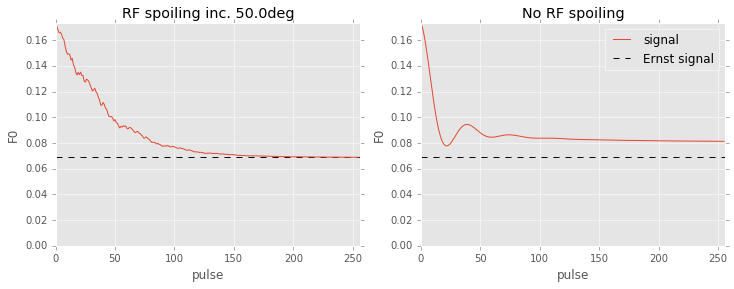

In [17]:
%matplotlib inline

f_, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(12,4))

mx = np.max(np.abs(O_nospoil.get_f(0)))

ax1.plot(np.abs(O_spoil.get_f(0)))
ax1.hlines(ernst_sig, 0, N, 'k', '--')
ax1.set_xlabel("pulse")
ax1.set_ylabel("F0")
ax1.set_ylim([0,mx])
ax1.set_xlim([0,N])
ax1.set_title("RF spoiling inc. {0:.1f}deg".format(rad2deg(phinc)))

ax2.plot(np.abs(O_nospoil.get_f(0)), label='signal')
ax2.hlines(ernst_sig, 0, N, 'k', '--', label='Ernst signal')
ax2.set_xlabel("pulse")
ax2.set_ylabel("F0")
ax2.set_ylim([0,mx])
ax2.set_xlim([0,N])
ax2.set_title("No RF spoiling")
legend();

It can be seen that RF spoiling with 50.0deg allows a signal amplitude which is basically conformant with the ernst signal, which is based on ideal spoiling. As expected without RF spoiling the signal levels are higher. Now let's systematically analyze different RF spoiling increments

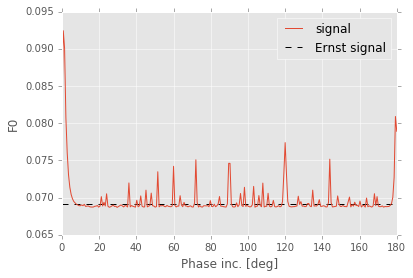

In [18]:
nincs = 256
steady_state_amplitudes = []
incs = linspace(0.0,180.0,nincs)

for inc in incs:
    T_phinc = operators.PhaseIncrementedTransform(alpha=np.deg2rad(alpha), phi=0.0, linear_phase_inc=deg2rad(inc), name="Excite")
    O_phinc = operators.Observer(f_states=(0,), z_states=())
    c_rfinc = operators.CompositeOperator(E_fast,S,O_phinc,T_phinc)
    
    phinc_graph = epg.EpyG(initial_size=256, m0=1.0)

    for i in range(N):
        c_rfinc*phinc_graph
    steady_state_amplitudes.append(O_phinc.get_f(0)[-1])    

steady_state_amplitudes = np.abs(steady_state_amplitudes)

plot(incs, steady_state_amplitudes, label='signal')
hlines(ernst_sig, 0, np.max(incs), 'k', '--', label='Ernst signal')
xlabel("Phase inc. [deg]")
ylabel("F0")
legend();


As we can see the actual choice of the phase increment is crucial for good RF spoiling. We can also appreciate that commonly used values of 50deg or 117deg are reasonable choices.

The EpyG library offers also premade operators for common tasks like GRE.



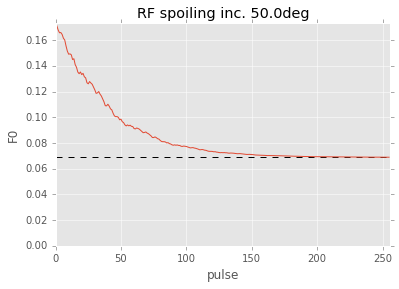

In [19]:
from EpyG.Applications import GRE_step
c_gre, o_gre = GRE_step(TR=10.0, T1=1000.0, T2=100.0, alpha_deg=10.0, phi_deg=0.0, linear_phase_inc_deg=50.0, d=None, observe=True)
e = epg.EpyG()

for i in range(256):
    c_gre * e
    
plot(np.abs(o_gre.get_f(0)))
hlines(ernst_sig, 0, N, 'k', '--')
xlabel("pulse")
ylabel("F0")
ylim([0,mx])
xlim([0,N])
title("RF spoiling inc. {0:.1f}deg".format(rad2deg(phinc)))


Of course we can use this to simulate more complex seqeunces. E.g an MPRAGE sequence

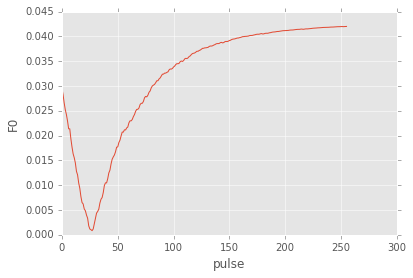

In [20]:
# Sequence definitions
ETL = 256
ES = 5.0
T1 = 1000.0
T2 = 100.0

TI = 1000.0
TD = TI - ETL/2 * ES
TR = 2500.0
TD2 = TR - TD - ETL*ES

# Necessary Operators
inv = operators.Transform(alpha=deg2rad(180.0), phi=0.0, name="Inversion")
inv_spoil = operators.Shift(shifts=10, name="Inversion spoiling")
td = operators.Epsilon(TR_over_T1=TD/T1, TR_over_T2=TD/T2)
td2 = operators.Epsilon(TR_over_T1=TD2/T1, TR_over_T2=TD2/T2)
c_gre, o_gre = GRE_step(TR=ES, T1=T1, T2=T2, alpha_deg=10.0, phi_deg=0.0, linear_phase_inc_deg=50.0, d=None, observe=True)
e = epg.EpyG()

for k in range(4):
    o_gre.clear()  # We clear the observer on each iteration - just to avoid having the approach to steady state recorded
    inv * e
    inv_spoil * e
    td * e
    for i in range(ETL):
        c_gre * e
    td2 * e    
        
plot(np.abs(o_gre.get_f(0)))
xlabel("pulse")
ylabel("F0")


As can be seen we can effectively model MPRAGE trains with the EpyG code. Downside of the above seen approach is that in the plot the relaxation periods are not displayed to scale with the other events. E.g. the whole relaxation of TD1 and TD2 happens 